# Data Exploration

## Setup

In [164]:
import hub
import numpy as np
import pandas as pd
import time
from scipy import signal
from matplotlib import pyplot as plt
from IPython import display

In [3]:
ds = hub.load("hub://activeloop/nsynth-test")
print("\n")
print("Opened access to NSynth. Sample Entry:")
print(ds)
print("\n")
print(f"There are {ds.instrument.shape[0]} audio samples of size {ds.audios.shape[1]}.")
print(f"The dataset has around {ds.audios.shape[0] * ds.audios.shape[1] * 64 / 8e9} gb of data.")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/nsynth-test loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/nsynth-test.


Opened access to NSynth. Sample Entry:
Dataset(path='hub://activeloop/nsynth-test', read_only=True, tensors=['audios', 'sample_rate', 'pitch', 'instrument_source', 'instrument_family', 'note', 'qualities', 'velocity', 'instrument'])


There are 4096 audio samples of size 64000.
The dataset has around 2.097152 gb of data.


## Visualize some data

In [99]:
N = 10
print(f"Try loading {N} data samples:")
start_t = time.time()
audio = ds.audios[:N].numpy()
end_t = time.time()
size = audio.itemsize * audio.size / 1e9
print(f"Loaded {size} gb of data in {end_t - start_t} seconds")

Try loading 10 data samples:
Loaded 0.00512 gb of data in 0.005957841873168945 seconds


In [100]:
print(f"Try loading {N} data labels:")
start_t = time.time()
labels = ds.instrument_family[:N].numpy().astype('int32').reshape(-1)
end_t = time.time()
size = labels.itemsize * labels.size / 1e9
print(f"Loaded {size} gb of data in {end_t - start_t} seconds")

Try loading 10 data labels:
Loaded 4e-08 gb of data in 0.0005421638488769531 seconds


In [101]:
sample_rate = ds.sample_rate[0].numpy()[0]

In [102]:
instruments = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']
instrument_index = dict([(v,i) for i, v in enumerate(instruments)])

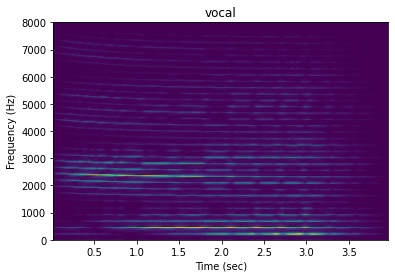

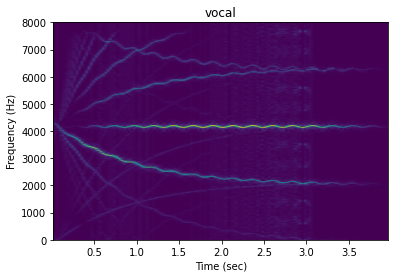

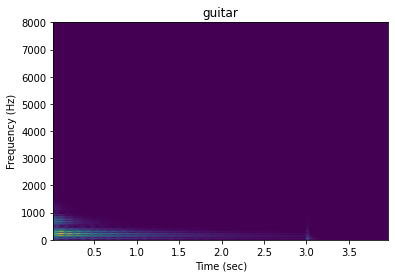

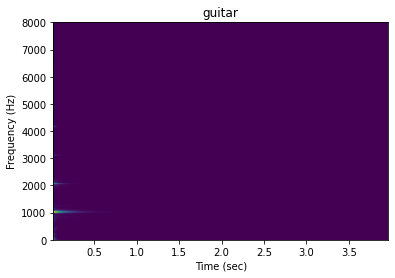

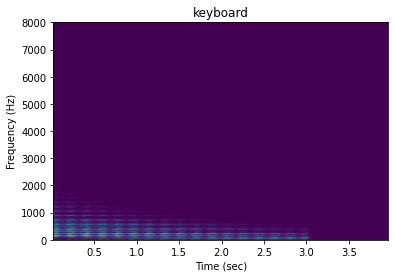

In [103]:
def clean_samples(samples):
    return samples.reshape((samples.shape[0], samples.shape[1])).astype('float32')


def fft(sample, sample_rate, window_size=512):
    """Create the Spectrogram.
    
    This returns an three arrays F (frequency), T (time), and S (spectrogram).
    The entry S[f,t] is the magnitude of frequency F[f] (in Hz) at time T[t] (in seconds).
    """
    f, t, s = signal.spectrogram(sample, fs=sample_rate, nperseg=window_size, mode='magnitude')
    return f, t, s


def visualize(f, t, s, instrument):
    plt.pcolormesh(t, f, s, shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.title(instrument)
    plt.show()

def fft_visualize(sample, label, sample_rate, window_size=512):
    visualize(*fft(sample, sample_rate, window_size=window_size), instruments[label])

samples = clean_samples(audio)

number_to_show = 5

for i in range(number_to_show):
    fft_visualize(samples[i], labels[i], sample_rate)
    show_audio = display.Audio(samples[i], rate=sample_rate)
    display.DisplayHandle().display(show_audio)

## Construct a subset of the dataset

In [74]:
def select_new_subset(selected_families, instruments_per_family=2, examples_per_instrument=None, verbose=True):
    """Pick a subset of the dataset by selecting random indices.
    
    The for each instrument family (keyboards, guitars, etc), there are many instruments.
    For each instrument (piano, harpsichord, clavinet), there are many samples.
    Each sample is one data point.
    
    This function extracts the indices of samples from randomly chosen instruments from
    the specificied selected instrument families.
    
    Params:
        selected_families: the codes for the instrument families to draw instruments from
        instruments_per_family: how many instruments per family to draw samples from
        examples_per_instrument: how many samples to draw per instrument
        
    Returns:
        a dictionary with keys:
            indices: the indices of the selected samples displayed as a flat array
            [instrument family code]:
                [instrument code]: a list of indices corresponding to the samples for this instrument
    """
    instrument_families = ds.instrument_family.numpy().astype('int32').reshape(-1)
    instruments = ds.instrument.numpy().astype('int32').reshape(-1)
    indices = np.arange(instruments.shape[0])
    selection = {
        'indices': np.array([]).astype(np.int32)
    }
    all_selected_instruments = set()
    for family in selected_families:
        if verbose:
            print("Get instruments for family ", family)
        instrument_codes = np.unique(instruments[instrument_families == family])
        selected_instruments = np.random.choice(instrument_codes, instruments_per_family, replace=False)
        selection[family] = {}
        
        for inst in selected_instruments:
            if verbose:
                print("Get samples for instrument ", inst)
            n = examples_per_instrument
            instrument_indices = indices[instruments == inst]
            if n is None:
                n = instrument_indices.shape[0]
            selected_samples = np.random.choice(instrument_indices, n, replace=False)
            selection[family][inst] = selected_samples
            selection['indices'] = np.concatenate([selection['indices'], selected_samples])
    return selection


def load_selection(selection, selection_subset_size=None, verbose=True):
    """Loads a dataset from the selected subset given by `selection`.
    
    selection_subset_size is used for debugging.
    
    Returns:
        dataframe with columns [id, instrument_family, instrument, audio]
    """
    if selection_subset_size is None:
        selection_subset_size = selection['indices'].shape[0]
    indices = list(np.sort(selection['indices']))[:selection_subset_size]
    instrument_families = ds.instrument_family[indices].numpy().astype('int32').reshape(-1)
    instruments = ds.instrument[indices].numpy().astype('int32').reshape(-1)
    if verbose:
        print(f"Load {len(indices)} samples")
    audio = clean_samples(ds.audios[indices].numpy())
    if verbose:
        print("Finished loading")
    df = pd.DataFrame({'id': indices, 'instrument_family': instrument_families, 'instrument': instruments})
    df['audio'] = list(audio)
    df = df.astype({'id': 'int32', 'instrument_family': 'int32', 'instrument': 'int32', 'audio': object})
    return df


selected_families = [instrument_index['keyboard'], instrument_index['mallet'], instrument_index['guitar'], instrument_index['bass']]
selection = select_new_subset(selected_families)
print(f"Selected {selection['indices'].shape} samples. Preparing to load the audio...")

Get instruments for family  4
Get samples for instrument  50
Get samples for instrument  838
Get instruments for family  5
Get samples for instrument  488
Get samples for instrument  644
Get instruments for family  3
Get samples for instrument  316
Get samples for instrument  510
Get instruments for family  0
Get samples for instrument  927
Get samples for instrument  803
Selected (744,) samples. Preparing to load the audio...


In [81]:
df_raw = load_selection(selection, selection_subset_size=None)
df_raw

Load 744 samples
Finished loading
Finished!


,id,instrument_family,instrument,audio
0,2,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,9,0,803,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,19,4,838,"[0.0, 0.0, 0.0, 3.0517578e-05, -6.1035156e-05,..."
4,22,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
739,4058,4,50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.1552734e..."
740,4063,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
741,4065,0,803,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
742,4070,5,488,"[-0.010406494, -0.077819824, -0.14929199, -0.0..."


In [162]:
class Spectrogram:
    def __init__(self, f, t, s, audio, sample_rate):
        self.f = f
        self.t = t
        self.s = s
        self.audio = audio
        self.sr = sample_rate
        
    def visualize(self):
        fig, ax = plt.subplots()
        ax.pcolormesh(self.t, self.f, self.s, shading='gouraud')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (sec)')
        return fig, ax
    
    def play(self):
        show_audio = display.Audio(self.audio, rate=self.sr)
        display.DisplayHandle().display(show_audio)

        
def create_spectrograms(df, sample_rate, window_size=512):
    audio = np.vstack(df['audio'])
    f, t, s = fft(audio, sample_rate, window_size=window_size)
    spectrograms = [Spectrogram(f, t, s[i], audio[i], sample_rate) for i in range(s.shape[0])]
    df['spectrogram'] = spectrograms
    return df

df = create_spectrograms(df_raw, sample_rate)
df

,id,instrument_family,instrument,audio,spectrogram
0,2,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<__main__.Spectrogram object at 0x7f81c80d4370>
1,9,0,803,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<__main__.Spectrogram object at 0x7f81c8434070>
2,10,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<__main__.Spectrogram object at 0x7f817fd0d070>
3,19,4,838,"[0.0, 0.0, 0.0, 3.0517578e-05, -6.1035156e-05,...",<__main__.Spectrogram object at 0x7f818b1cafa0>
4,22,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<__main__.Spectrogram object at 0x7f81c8144c10>
...,...,...,...,...,...
739,4058,4,50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.1552734e...",<__main__.Spectrogram object at 0x7f818b19bc40>
740,4063,3,510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<__main__.Spectrogram object at 0x7f818b19bca0>
741,4065,0,803,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<__main__.Spectrogram object at 0x7f818b19bd00>
742,4070,5,488,"[-0.010406494, -0.077819824, -0.14929199, -0.0...",<__main__.Spectrogram object at 0x7f818b19bd60>


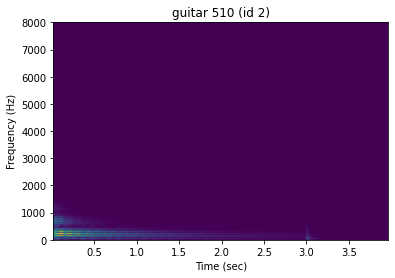

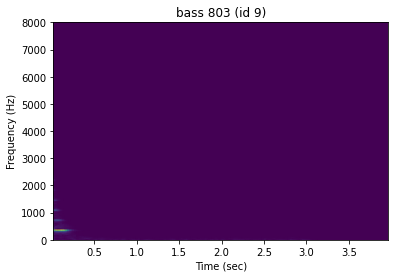

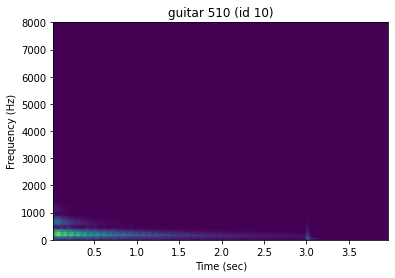

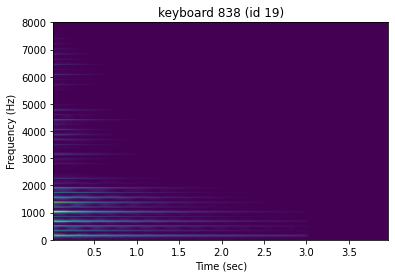

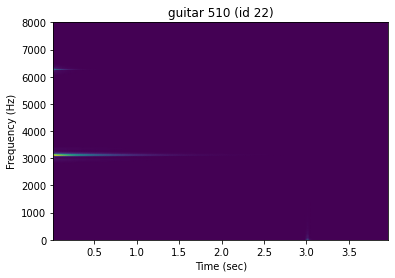

In [163]:
num_to_visualize = 5
for i in range(num_to_visualize):
    spectrogram = df.iloc[i]['spectrogram']
    fig, ax = spectrogram.visualize()
    instrument_family = instruments[df.iloc[i]['instrument_family']]
    instrument = df.iloc[i]['instrument']
    ax.set_title(f"{instrument_family} {instrument} (id {df.iloc[i]['id']})")
    plt.show(fig)
    spectrogram.play()